MODEL 1 — LIGHTWEIGHT CNN (BASELINE)

In [20]:
# ============================================
# BLOCK 1: Install Dependencies
# ============================================
!pip install split-folders
!pip install torch-summary

In [21]:
# ============================================
# BLOCK 2: Import Libraries
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [22]:
# ============================================
# BLOCK 3: Load and Check Dataset
# ============================================
labels_df = pd.read_csv('/content/metadata.csv')
print(labels_df.head().to_markdown())
print(f"\nDataset shape: {labels_df.shape}")

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |

Dataset shape: (4600, 6)


In [23]:
# ============================================
# BLOCK 4: Unzip Dataset
# ============================================
!unzip -q Brain_Tumor_Dataset.zip -d /content/Brain_Tumor_Dataset

In [24]:
# ============================================
# BLOCK 5: Data Transforms and Loaders
# ============================================
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch, numpy as np

# Separate transforms
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Build a "plain" dataset (no transform yet)
root_dir = "/content/Brain_Tumor_Dataset/Brain_Tumor_Dataset"
plain_ds = datasets.ImageFolder(root=root_dir, transform=None)

# Split indices once
rng = torch.Generator().manual_seed(42)
n = len(plain_ds)
train_size = int(0.7*n)
val_size   = int(0.15*n)
test_size  = n - train_size - val_size

print(f"\nDataset Split:")
print(f"Total images: {n}")
print(f"Training: {train_size} ({train_size/n*100:.1f}%)")
print(f"Validation: {val_size} ({val_size/n*100:.1f}%)")
print(f"Testing: {test_size} ({test_size/n*100:.1f}%)")

train_idx, val_idx, test_idx = torch.utils.data.random_split(
    range(n), [train_size, val_size, test_size], generator=rng
)

# Wrap subsets with transforms per split
class TransformWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, indices, transform):
        self.base_ds = base_ds
        self.indices = list(indices)
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        path, target = self.base_ds.samples[self.indices[i]]
        img = self.base_ds.loader(path)
        if self.transform: img = self.transform(img)
        return img, target

train_set = TransformWrapper(plain_ds, train_idx, train_transform)
val_set   = TransformWrapper(plain_ds, val_idx,   eval_transform)
test_set  = TransformWrapper(plain_ds, test_idx,  eval_transform)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nDataLoaders created successfully!")
print(f"Batch size: {batch_size}")


Dataset Split:
Total images: 4600
Training: 3220 (70.0%)
Validation: 690 (15.0%)
Testing: 690 (15.0%)

DataLoaders created successfully!
Batch size: 64


In [25]:
# ============================================
# BLOCK 6: Define Model Architecture
# ============================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_TUMOR(nn.Module):
    def __init__(self, params):
        super().__init__()
        Cin, Hin, Win = params["shape_in"]
        init_f        = params["initial_filters"]
        num_fc1       = params["num_fc1"]
        num_classes   = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # 3x3 convolutions
        self.conv1 = nn.Conv2d(Cin,        init_f,   kernel_size=3)
        self.conv2 = nn.Conv2d(init_f,     2*init_f, kernel_size=3)
        self.conv3 = nn.Conv2d(2*init_f,   4*init_f, kernel_size=3)
        self.conv4 = nn.Conv2d(4*init_f,   8*init_f, kernel_size=3)

        # Global Average Pool
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(8*init_f, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X)); X = F.max_pool2d(X, 2, 2)
        X = self.gap(X)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate, training=self.training)
        X = self.fc2(X)
        return X

In [26]:
# ============================================
# BLOCK 7: Initialize Model
# ============================================
params_model = {
    "shape_in": (3,256,256),
    "initial_filters": 16,
    "num_fc1": 256,
    "dropout_rate": 0.25,
    "num_classes": 2
}

cnn_model = CNN_TUMOR(params_model)
print("Model architecture:")
print(cnn_model)

Model architecture:
CNN_TUMOR(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [27]:
# ============================================
# BLOCK 8: Define Loss, Optimizer, Scheduler
# ============================================
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss function
loss_func = torch.nn.CrossEntropyLoss()

# Optimizer
opt = optim.Adam(cnn_model.parameters(), lr=3e-4, weight_decay=1e-5)

# Scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

print("\nLoss function: CrossEntropyLoss")
print("Optimizer: Adam (lr=3e-4, weight_decay=1e-5)")
print("Scheduler: ReduceLROnPlateau")


Loss function: CrossEntropyLoss
Optimizer: Adam (lr=3e-4, weight_decay=1e-5)
Scheduler: ReduceLROnPlateau


In [28]:
# ============================================
# BLOCK 9: Training & Evaluation Utilities
# ============================================
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = cnn_model.to(device)
print(f"\nUsing device: {device}")

def run_epoch(model, loader, criterion, optimizer=None, scaler=None):
    """
    If optimizer is provided -> training mode; otherwise eval mode.
    Returns avg_loss, y_true(list), y_pred(list)
    """
    is_train = optimizer is not None
    model.train(is_train)
    epoch_loss = 0.0
    y_true, y_pred = [], []

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        # Mixed precision if CUDA available
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            logits = model(X)
            loss = criterion(logits, y)

        if is_train:
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())

    avg_loss = epoch_loss / len(loader.dataset)
    return avg_loss, y_true, y_pred


def evaluate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='binary')
    return acc, f1


Using device: cuda


In [29]:
# ============================================
# BLOCK 10: Training Loop with History Tracking
# ============================================
num_epochs = 30
best_val_loss = float('inf')
best_state = None
patience = 10
epochs_no_improve = 0

# Initialize history lists
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_f1s = []
val_f1s = []

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(1, num_epochs + 1):
    train_loss, y_tr, yhat_tr = run_epoch(cnn_model, train_loader, loss_func, optimizer=opt, scaler=scaler)
    tr_acc, tr_f1 = evaluate_metrics(y_tr, yhat_tr)

    with torch.no_grad():
        val_loss, y_va, yhat_va = run_epoch(cnn_model, val_loader, loss_func, optimizer=None)
        va_acc, va_f1 = evaluate_metrics(y_va, yhat_va)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)
    train_f1s.append(tr_f1)
    val_f1s.append(va_f1)

    # Step LR scheduler with validation loss
    lr_scheduler.step(val_loss)
    current_lr = opt.param_groups[0]['lr']

    print(f"[Epoch {epoch:02d}/{num_epochs}] "
          f"train_loss={train_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={val_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"lr={current_lr:.2e}")

    # Early stopping on validation loss
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = {
            'epoch': epoch,
            'model_state': cnn_model.state_dict(),
            'opt_state': opt.state_dict(),
            'best_val_loss': best_val_loss,
        }
        torch.save(best_state, '/content/best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

print("\n" + "="*60)
print("Training complete. Best val loss:", best_val_loss)
print("="*60)



STARTING TRAINING
[Epoch 01/30] train_loss=0.6903 acc=0.5379 f1=0.2168 | val_loss=0.6820 acc=0.5652 f1=0.0000 | lr=3.00e-04
[Epoch 02/30] train_loss=0.6851 acc=0.5699 f1=0.2369 | val_loss=0.6687 acc=0.6217 f1=0.2927 | lr=3.00e-04
[Epoch 03/30] train_loss=0.6704 acc=0.5839 f1=0.4384 | val_loss=0.6405 acc=0.6319 f1=0.3420 | lr=3.00e-04
[Epoch 04/30] train_loss=0.6450 acc=0.6317 f1=0.5581 | val_loss=0.6063 acc=0.7174 f1=0.6689 | lr=3.00e-04
[Epoch 05/30] train_loss=0.6107 acc=0.6736 f1=0.6248 | val_loss=0.5672 acc=0.7377 f1=0.6578 | lr=3.00e-04
[Epoch 06/30] train_loss=0.5885 acc=0.6832 f1=0.6304 | val_loss=0.6213 acc=0.6696 f1=0.6894 | lr=3.00e-04
[Epoch 07/30] train_loss=0.5647 acc=0.7099 f1=0.6667 | val_loss=0.5850 acc=0.7000 f1=0.7137 | lr=3.00e-04
[Epoch 08/30] train_loss=0.5493 acc=0.7224 f1=0.6805 | val_loss=0.5212 acc=0.7406 f1=0.6441 | lr=3.00e-04
[Epoch 09/30] train_loss=0.5237 acc=0.7410 f1=0.6961 | val_loss=0.5078 acc=0.7493 f1=0.6790 | lr=3.00e-04
[Epoch 10/30] train_loss=0.

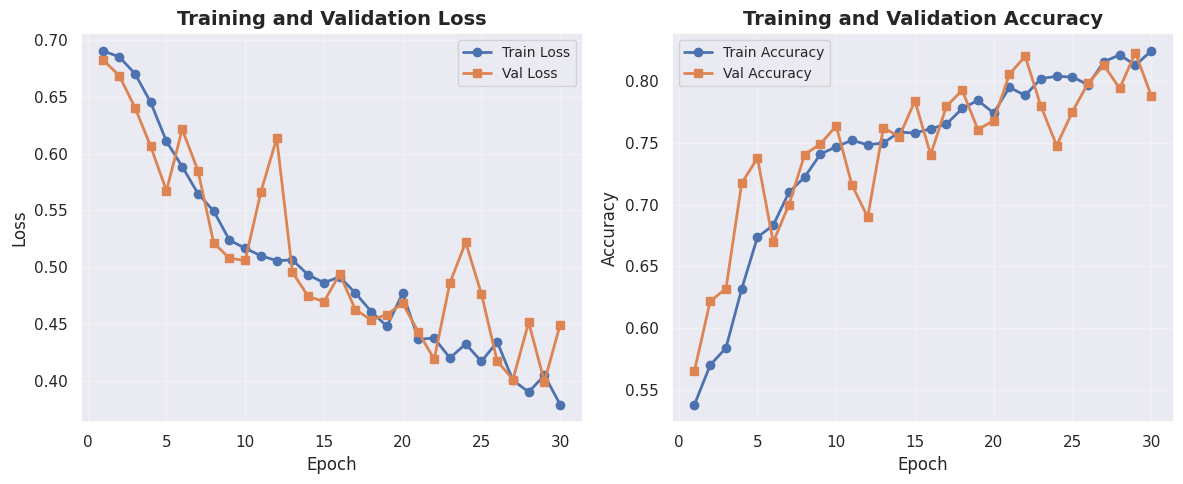

✓ Training curves saved as 'training_curves.png'


In [30]:
# ============================================
# BLOCK 11: Plot Training Curves
# ============================================
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o', linewidth=2)
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o', linewidth=2)
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved as 'training_curves.png'")


In [31]:
# ============================================
# BLOCK 12: Print Training Summary
# ============================================
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs Trained: {len(train_losses)}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"\nFinal Training Metrics:")
print(f"  - Loss: {train_losses[-1]:.4f}")
print(f"  - Accuracy: {train_accs[-1]:.4f}")
print(f"  - F1-Score: {train_f1s[-1]:.4f}")
print(f"\nFinal Validation Metrics:")
print(f"  - Loss: {val_losses[-1]:.4f}")
print(f"  - Accuracy: {val_accs[-1]:.4f}")
print(f"  - F1-Score: {val_f1s[-1]:.4f}")
print("="*60 + "\n")


TRAINING SUMMARY
Total Epochs Trained: 30
Best Validation Loss: 0.3990

Final Training Metrics:
  - Loss: 0.3788
  - Accuracy: 0.8245
  - F1-Score: 0.8084

Final Validation Metrics:
  - Loss: 0.4493
  - Accuracy: 0.7884
  - F1-Score: 0.7902



In [32]:
# ============================================
# BLOCK 13: Test Set Evaluation
# ============================================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load best model
ckpt = torch.load('/content/best_model.pt', map_location=device)
cnn_model.load_state_dict(ckpt['model_state'])
cnn_model.eval()

def collect_preds(model, loader, device):
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device); y = y.to(device)
            logits = model(X)
            prob = torch.softmax(logits, dim=1)[:, 1]
            pred = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())
            y_prob.extend(prob.cpu().tolist())
    return y_true, y_pred, y_prob

# Collect predictions
y_te, yhat_te, yprob_te = collect_preds(cnn_model, test_loader, device)

# Print metrics
print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_te, yhat_te, digits=4, target_names=['No Tumor', 'Tumor']))

# Calculate test accuracy
test_acc = accuracy_score(y_te, yhat_te)
print(f"\nTest Accuracy: {test_acc:.4f}")

# ROC-AUC
try:
    roc_auc = roc_auc_score(y_te, yprob_te)
    print(f"Test ROC-AUC: {roc_auc:.4f}")
except Exception as e:
    print(f"ROC-AUC not available: {e}")

print("="*60 + "\n")



TEST SET RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Tumor     0.8587    0.8360    0.8472       378
       Tumor     0.8075    0.8333    0.8202       312

    accuracy                         0.8348       690
   macro avg     0.8331    0.8347    0.8337       690
weighted avg     0.8355    0.8348    0.8350       690


Test Accuracy: 0.8348
Test ROC-AUC: 0.9230



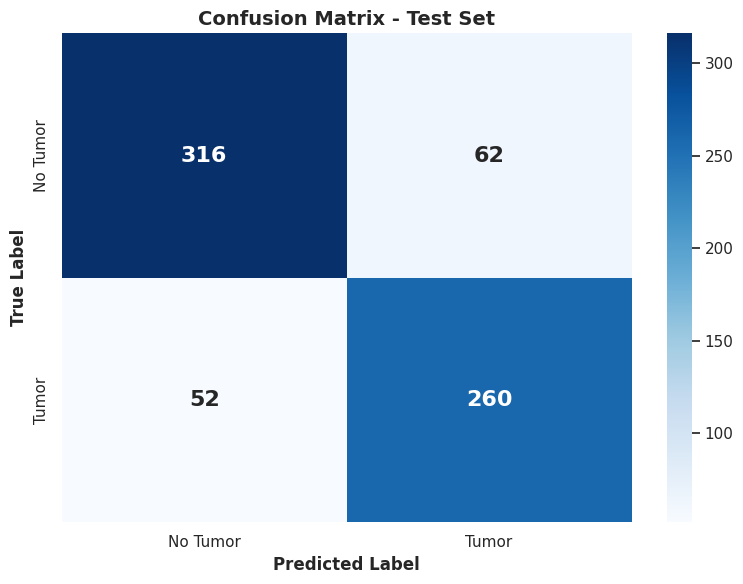

✓ Confusion matrix saved as 'confusion_matrix.png'


In [33]:
# ============================================
# BLOCK 14: Confusion Matrix Visualization
# ============================================
# Get confusion matrix
cm = confusion_matrix(y_te, yhat_te)

# Create figure
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            annot_kws={"size": 16, "weight": "bold"})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")


In [34]:
# ============================================
# BLOCK 15: Detailed Metrics Summary
# ============================================
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate per-class metrics
precision_0 = precision_score(y_te, yhat_te, pos_label=0)
recall_0 = recall_score(y_te, yhat_te, pos_label=0)
f1_0 = f1_score(y_te, yhat_te, pos_label=0)

precision_1 = precision_score(y_te, yhat_te, pos_label=1)
recall_1 = recall_score(y_te, yhat_te, pos_label=1)
f1_1 = f1_score(y_te, yhat_te, pos_label=1)

# Create summary table
print("\n" + "="*60)
print("DETAILED METRICS SUMMARY")
print("="*60)
print(f"\n{'Metric':<25} {'No Tumor (Class 0)':<20} {'Tumor (Class 1)':<20}")
print("-"*60)
print(f"{'Precision':<25} {precision_0:<20.4f} {precision_1:<20.4f}")
print(f"{'Recall':<25} {recall_0:<20.4f} {recall_1:<20.4f}")
print(f"{'F1-Score':<25} {f1_0:<20.4f} {f1_1:<20.4f}")
print("-"*60)
print(f"{'Overall Accuracy':<25} {test_acc:<20.4f}")
try:
    print(f"{'ROC-AUC Score':<25} {roc_auc:<20.4f}")
except:
    pass
print("="*60 + "\n")


DETAILED METRICS SUMMARY

Metric                    No Tumor (Class 0)   Tumor (Class 1)     
------------------------------------------------------------
Precision                 0.8587               0.8075              
Recall                    0.8360               0.8333              
F1-Score                  0.8472               0.8202              
------------------------------------------------------------
Overall Accuracy          0.8348              
ROC-AUC Score             0.9230              



In [35]:
# ============================================
# BLOCK 16: Save Metrics to CSV
# ============================================
import pandas as pd

# Create metrics dataframe
metrics_dict = {
    'Metric': ['Test Accuracy', 'Test ROC-AUC',
               'Precision (No Tumor)', 'Recall (No Tumor)', 'F1-Score (No Tumor)',
               'Precision (Tumor)', 'Recall (Tumor)', 'F1-Score (Tumor)',
               'Best Val Loss', 'Final Train Loss', 'Final Val Loss'],
    'Value': [test_acc, roc_auc if 'roc_auc' in locals() else 'N/A',
              precision_0, recall_0, f1_0,
              precision_1, recall_1, f1_1,
              best_val_loss, train_losses[-1], val_losses[-1]]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv('/content/model_metrics.csv', index=False)
print("✓ Metrics saved to 'model_metrics.csv'")
print("\n" + metrics_df.to_string(index=False))

print("\n" + "="*60)
print("ALL DONE! ✓")
print("="*60)

✓ Metrics saved to 'model_metrics.csv'

              Metric    Value
       Test Accuracy 0.834783
        Test ROC-AUC 0.923009
Precision (No Tumor) 0.858696
   Recall (No Tumor) 0.835979
 F1-Score (No Tumor) 0.847185
   Precision (Tumor) 0.807453
      Recall (Tumor) 0.833333
    F1-Score (Tumor) 0.820189
       Best Val Loss 0.398966
    Final Train Loss 0.378834
      Final Val Loss 0.449340

ALL DONE! ✓


Model 2: ResNet18

In [1]:
# ============================================
# BLOCK 1: Install Dependencies
# ============================================
!pip install split-folders
!pip install torch-summary


In [2]:
# ============================================
# BLOCK 2: Import Libraries
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils, models
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')


In [3]:
# ============================================
# BLOCK 3: Load and Check Dataset
# ============================================
labels_df = pd.read_csv('/content/metadata.csv')
print(labels_df.head().to_markdown())
print(f"\nDataset shape: {labels_df.shape}")

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |

Dataset shape: (4600, 6)


In [7]:
# ============================================
# BLOCK 4: Unzip Dataset
# ============================================
!unzip -q Brain_Tumor_Dataset.zip -d /content/Brain_Tumor_Dataset

In [8]:
# ============================================
# BLOCK 5: Data Transforms and Loaders
# ============================================
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch, numpy as np

# Separate transforms
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Build a "plain" dataset (no transform yet)
root_dir = "/content/Brain_Tumor_Dataset/Brain_Tumor_Dataset"
plain_ds = datasets.ImageFolder(root=root_dir, transform=None)

# Split indices once
rng = torch.Generator().manual_seed(42)
n = len(plain_ds)
train_size = int(0.7*n)
val_size   = int(0.15*n)
test_size  = n - train_size - val_size

print(f"\nDataset Split:")
print(f"Total images: {n}")
print(f"Training: {train_size} ({train_size/n*100:.1f}%)")
print(f"Validation: {val_size} ({val_size/n*100:.1f}%)")
print(f"Testing: {test_size} ({test_size/n*100:.1f}%)")

train_idx, val_idx, test_idx = torch.utils.data.random_split(
    range(n), [train_size, val_size, test_size], generator=rng
)

# Wrap subsets with transforms per split
class TransformWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, indices, transform):
        self.base_ds = base_ds
        self.indices = list(indices)
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        path, target = self.base_ds.samples[self.indices[i]]
        img = self.base_ds.loader(path)
        if self.transform: img = self.transform(img)
        return img, target

train_set = TransformWrapper(plain_ds, train_idx, train_transform)
val_set   = TransformWrapper(plain_ds, val_idx,   eval_transform)
test_set  = TransformWrapper(plain_ds, test_idx,  eval_transform)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nDataLoaders created successfully!")
print(f"Batch size: {batch_size}")


Dataset Split:
Total images: 4600
Training: 3220 (70.0%)
Validation: 690 (15.0%)
Testing: 690 (15.0%)

DataLoaders created successfully!
Batch size: 64


In [9]:
# ============================================
# BLOCK 6: Build ResNet18 Model
# ============================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

def build_resnet18(num_classes=2, dropout_p=0.0):
    # PyTorch 2.x API:
    weights = models.ResNet18_Weights.DEFAULT  # ImageNet pretrained
    net = models.resnet18(weights=weights)
    in_features = net.fc.in_features

    # Optional dropout before the final FC
    if dropout_p > 0:
        net.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features, num_classes)
        )
    else:
        net.fc = nn.Linear(in_features, num_classes)

    return net

resnet = build_resnet18(num_classes=2, dropout_p=0.2).to(device)
print("\nResNet18 model created with dropout=0.2")
print("Final classifier:", resnet.fc)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]



ResNet18 model created with dropout=0.2
Final classifier: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=512, out_features=2, bias=True)
)


In [10]:
# ============================================
# BLOCK 7: Training & Evaluation Utilities
# ============================================
from sklearn.metrics import accuracy_score, f1_score

def run_epoch(model, loader, criterion, optimizer=None, scaler=None):
    """
    If optimizer is provided -> training mode; otherwise eval mode.
    Returns avg_loss, y_true(list), y_pred(list)
    """
    is_train = optimizer is not None
    model.train(is_train)
    epoch_loss = 0.0
    y_true, y_pred = [], []

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            logits = model(X)
            loss = criterion(logits, y)

        if is_train:
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())

    avg_loss = epoch_loss / len(loader.dataset)
    return avg_loss, y_true, y_pred


def evaluate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='binary')
    return acc, f1


In [11]:
# ============================================
# BLOCK 8: Warmup Phase - Freeze Backbone
# ============================================
print("\n" + "="*60)
print("PHASE 1: WARMUP (Head Only Training)")
print("="*60)

# Freeze all except the new head
for name, p in resnet.named_parameters():
    p.requires_grad = False
for p in resnet.fc.parameters():
    p.requires_grad = True

# Optimizer for head only (larger LR is fine)
head_opt = optim.AdamW(resnet.fc.parameters(), lr=1e-3, weight_decay=1e-4)

# Loss function
ce_loss = nn.CrossEntropyLoss()

# Initialize history for warmup
warmup_train_losses = []
warmup_val_losses = []
warmup_train_accs = []
warmup_val_accs = []
warmup_train_f1s = []
warmup_val_f1s = []

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

warmup_epochs = 3
for epoch in range(1, warmup_epochs + 1):
    tr_loss, y_tr, yhat_tr = run_epoch(resnet, train_loader, ce_loss, optimizer=head_opt, scaler=scaler)
    tr_acc, tr_f1 = evaluate_metrics(y_tr, yhat_tr)

    with torch.no_grad():
        va_loss, y_va, yhat_va = run_epoch(resnet, val_loader, ce_loss, optimizer=None)
        va_acc, va_f1 = evaluate_metrics(y_va, yhat_va)

    # Store metrics
    warmup_train_losses.append(tr_loss)
    warmup_val_losses.append(va_loss)
    warmup_train_accs.append(tr_acc)
    warmup_val_accs.append(va_acc)
    warmup_train_f1s.append(tr_f1)
    warmup_val_f1s.append(va_f1)

    print(f"[Warmup {epoch}/{warmup_epochs}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f}")

print("Warmup phase complete!\n")


PHASE 1: WARMUP (Head Only Training)
[Warmup 1/3] train_loss=0.5909 acc=0.6851 f1=0.6409 | val_loss=0.4475 acc=0.8116 f1=0.7601
[Warmup 2/3] train_loss=0.4329 acc=0.7981 f1=0.7762 | val_loss=0.3722 acc=0.8420 f1=0.8162
[Warmup 3/3] train_loss=0.3842 acc=0.8339 f1=0.8153 | val_loss=0.3418 acc=0.8638 f1=0.8418
Warmup phase complete!



In [12]:
# ============================================
# BLOCK 9: Fine-Tuning Phase - Unfreeze Backbone
# ============================================
print("="*60)
print("PHASE 2: FINE-TUNING (Full Network)")
print("="*60)

# Unfreeze entire network
for p in resnet.parameters():
    p.requires_grad = True

# Smaller LR for backbone, slightly larger for the new head
backbone_params, head_params = [], []
for name, p in resnet.named_parameters():
    (head_params if "fc" in name else backbone_params).append(p)

opt = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4, "weight_decay": 1e-4},
    {"params": head_params,     "lr": 5e-4, "weight_decay": 1e-4},
])

# Reduce LR when val loss plateaus
lr_sched = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5, min_lr=1e-6)

# Initialize history for fine-tuning
ft_train_losses = []
ft_val_losses = []
ft_train_accs = []
ft_val_accs = []
ft_train_f1s = []
ft_val_f1s = []

num_epochs = 20
best_val_loss = float("inf")
epochs_no_improve = 0
patience = 8

for epoch in range(1, num_epochs + 1):
    tr_loss, y_tr, yhat_tr = run_epoch(resnet, train_loader, ce_loss, optimizer=opt, scaler=scaler)
    tr_acc, tr_f1 = evaluate_metrics(y_tr, yhat_tr)

    with torch.no_grad():
        va_loss, y_va, yhat_va = run_epoch(resnet, val_loader, ce_loss, optimizer=None)
        va_acc, va_f1 = evaluate_metrics(y_va, yhat_va)

    # Store metrics
    ft_train_losses.append(tr_loss)
    ft_val_losses.append(va_loss)
    ft_train_accs.append(tr_acc)
    ft_val_accs.append(va_acc)
    ft_train_f1s.append(tr_f1)
    ft_val_f1s.append(va_f1)

    lr_sched.step(va_loss)
    lrs = [g["lr"] for g in opt.param_groups]
    print(f"[FT {epoch:02d}/{num_epochs}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"lr_backbone={lrs[0]:.2e} lr_head={lrs[1]:.2e}")

    if va_loss < best_val_loss - 1e-6:
        best_val_loss = va_loss
        torch.save({"model_state": resnet.state_dict()}, "/content/best_resnet18.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

print("\n" + "="*60)
print(f"Fine-tuning complete! Best val loss: {best_val_loss:.4f}")
print("="*60)


PHASE 2: FINE-TUNING (Full Network)
[FT 01/20] train_loss=0.1732 acc=0.9320 f1=0.9256 | val_loss=0.0627 acc=0.9725 f1=0.9683 | lr_backbone=1.00e-04 lr_head=5.00e-04
[FT 02/20] train_loss=0.0500 acc=0.9829 f1=0.9814 | val_loss=0.0575 acc=0.9826 f1=0.9802 | lr_backbone=1.00e-04 lr_head=5.00e-04
[FT 03/20] train_loss=0.0209 acc=0.9919 f1=0.9912 | val_loss=0.0655 acc=0.9841 f1=0.9815 | lr_backbone=1.00e-04 lr_head=5.00e-04
[FT 04/20] train_loss=0.0208 acc=0.9932 f1=0.9925 | val_loss=0.0916 acc=0.9797 f1=0.9771 | lr_backbone=1.00e-04 lr_head=5.00e-04
[FT 05/20] train_loss=0.0173 acc=0.9947 f1=0.9942 | val_loss=0.0393 acc=0.9884 f1=0.9868 | lr_backbone=1.00e-04 lr_head=5.00e-04
[FT 06/20] train_loss=0.0115 acc=0.9941 f1=0.9936 | val_loss=0.0645 acc=0.9841 f1=0.9818 | lr_backbone=1.00e-04 lr_head=5.00e-04
[FT 07/20] train_loss=0.0128 acc=0.9960 f1=0.9956 | val_loss=0.0620 acc=0.9826 f1=0.9802 | lr_backbone=1.00e-04 lr_head=5.00e-04
[FT 08/20] train_loss=0.0105 acc=0.9969 f1=0.9966 | val_loss=

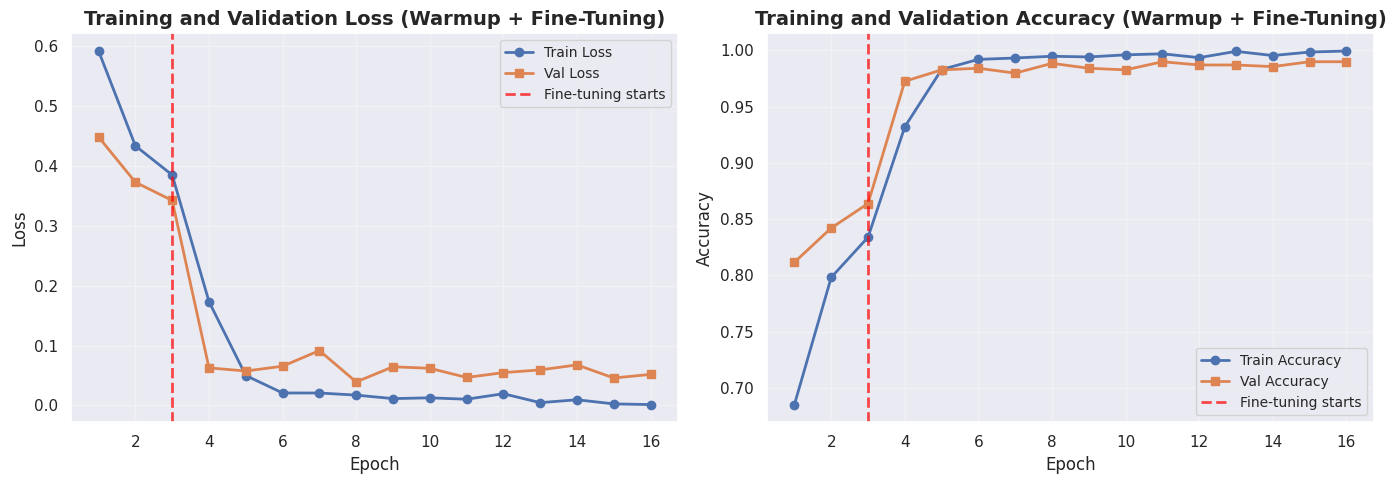

✓ Training curves saved as 'resnet18_training_curves.png'


In [13]:
# ============================================
# BLOCK 10: Plot Training Curves (Combined)
# ============================================
# Combine warmup + fine-tuning
all_train_losses = warmup_train_losses + ft_train_losses
all_val_losses = warmup_val_losses + ft_val_losses
all_train_accs = warmup_train_accs + ft_train_accs
all_val_accs = warmup_val_accs + ft_val_accs

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label='Train Loss', marker='o', linewidth=2)
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label='Val Loss', marker='s', linewidth=2)
plt.axvline(x=warmup_epochs, color='red', linestyle='--', linewidth=2, label='Fine-tuning starts', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss (Warmup + Fine-Tuning)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(all_train_accs) + 1), all_train_accs, label='Train Accuracy', marker='o', linewidth=2)
plt.plot(range(1, len(all_val_accs) + 1), all_val_accs, label='Val Accuracy', marker='s', linewidth=2)
plt.axvline(x=warmup_epochs, color='red', linestyle='--', linewidth=2, label='Fine-tuning starts', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy (Warmup + Fine-Tuning)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/resnet18_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved as 'resnet18_training_curves.png'")


In [14]:
# ============================================
# BLOCK 11: Print Training Summary
# ============================================
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Warmup Epochs: {warmup_epochs}")
print(f"Fine-Tuning Epochs: {len(ft_train_losses)}")
print(f"Total Epochs: {len(all_train_losses)}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

print(f"\nWarmup Phase - Final Metrics:")
print(f"  Train Loss: {warmup_train_losses[-1]:.4f}, Acc: {warmup_train_accs[-1]:.4f}, F1: {warmup_train_f1s[-1]:.4f}")
print(f"  Val Loss: {warmup_val_losses[-1]:.4f}, Acc: {warmup_val_accs[-1]:.4f}, F1: {warmup_val_f1s[-1]:.4f}")

print(f"\nFine-Tuning Phase - Final Metrics:")
print(f"  Train Loss: {ft_train_losses[-1]:.4f}, Acc: {ft_train_accs[-1]:.4f}, F1: {ft_train_f1s[-1]:.4f}")
print(f"  Val Loss: {ft_val_losses[-1]:.4f}, Acc: {ft_val_accs[-1]:.4f}, F1: {ft_val_f1s[-1]:.4f}")
print("="*60 + "\n")



TRAINING SUMMARY
Warmup Epochs: 3
Fine-Tuning Epochs: 13
Total Epochs: 16
Best Validation Loss: 0.0393

Warmup Phase - Final Metrics:
  Train Loss: 0.3842, Acc: 0.8339, F1: 0.8153
  Val Loss: 0.3418, Acc: 0.8638, F1: 0.8418

Fine-Tuning Phase - Final Metrics:
  Train Loss: 0.0015, Acc: 0.9994, F1: 0.9993
  Val Loss: 0.0518, Acc: 0.9899, F1: 0.9885



In [15]:
# ============================================
# BLOCK 12: Test Set Evaluation
# ============================================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

ckpt = torch.load("/content/best_resnet18.pt", map_location=device)
resnet.load_state_dict(ckpt["model_state"])
resnet.eval()

def collect_preds(model, loader, device):
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device); y = y.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                logits = model(X)
                prob = torch.softmax(logits, dim=1)[:, 1]
                pred = torch.argmax(logits, dim=1)
            y_true += y.cpu().tolist()
            y_pred += pred.cpu().tolist()
            y_prob += prob.cpu().tolist()
    return y_true, y_pred, y_prob

y_te, yhat_te, yprob_te = collect_preds(resnet, test_loader, device)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_te, yhat_te, digits=4, target_names=['No Tumor', 'Tumor']))

test_acc = accuracy_score(y_te, yhat_te)
print(f"\nTest Accuracy: {test_acc:.4f}")

roc_auc = roc_auc_score(y_te, yprob_te)
print(f"Test ROC-AUC: {roc_auc:.4f}")
print("="*60 + "\n")


TEST SET RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Tumor     1.0000    0.9841    0.9920       378
       Tumor     0.9811    1.0000    0.9905       312

    accuracy                         0.9913       690
   macro avg     0.9906    0.9921    0.9912       690
weighted avg     0.9915    0.9913    0.9913       690


Test Accuracy: 0.9913
Test ROC-AUC: 0.9996



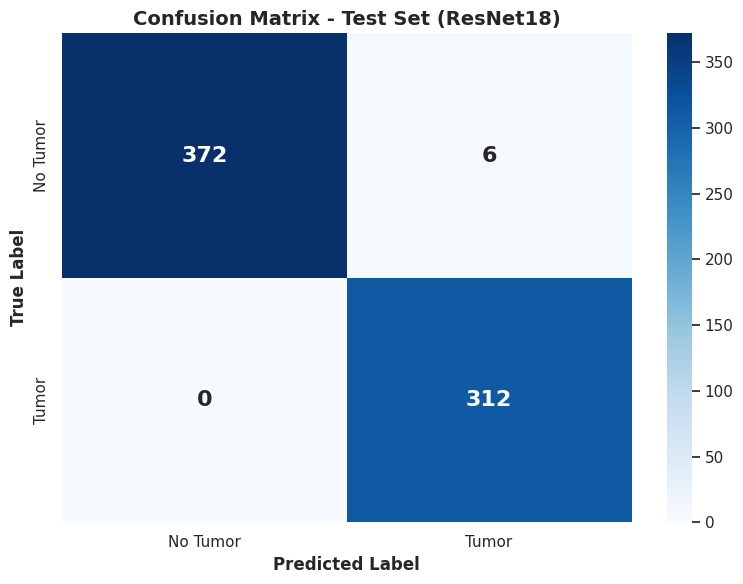

✓ Confusion matrix saved as 'resnet18_confusion_matrix.png'


In [16]:
# ============================================
# BLOCK 13: Confusion Matrix Visualization
# ============================================
cm = confusion_matrix(y_te, yhat_te)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            annot_kws={"size": 16, "weight": "bold"})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set (ResNet18)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/resnet18_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'resnet18_confusion_matrix.png'")


In [17]:
# ============================================
# BLOCK 14: Threshold Sweep Analysis
# ============================================
from sklearn.metrics import precision_score, recall_score, f1_score

print("\n" + "="*60)
print("THRESHOLD SWEEP ANALYSIS")
print("="*60)
print(f"\n{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*60)

thresholds = np.linspace(0.3, 0.7, 9)
threshold_results = []

for t in thresholds:
    preds_t = (np.array(yprob_te) > t).astype(int)
    P = precision_score(y_te, preds_t)
    R = recall_score(y_te, preds_t)
    F = f1_score(y_te, preds_t)
    threshold_results.append({'threshold': t, 'precision': P, 'recall': R, 'f1': F})
    print(f"{t:<12.2f} {P:<12.3f} {R:<12.3f} {F:<12.3f}")

print("="*60 + "\n")



THRESHOLD SWEEP ANALYSIS

Threshold    Precision    Recall       F1-Score    
------------------------------------------------------------
0.30         0.975        1.000        0.987       
0.35         0.975        1.000        0.987       
0.40         0.978        1.000        0.989       
0.45         0.981        1.000        0.990       
0.50         0.981        1.000        0.990       
0.55         0.981        1.000        0.990       
0.60         0.981        0.997        0.989       
0.65         0.984        0.994        0.989       
0.70         0.987        0.994        0.990       



In [18]:
# ============================================
# BLOCK 15: Detailed Metrics Summary
# ============================================
from sklearn.metrics import precision_score, recall_score, f1_score

precision_0 = precision_score(y_te, yhat_te, pos_label=0)
recall_0 = recall_score(y_te, yhat_te, pos_label=0)
f1_0 = f1_score(y_te, yhat_te, pos_label=0)

precision_1 = precision_score(y_te, yhat_te, pos_label=1)
recall_1 = recall_score(y_te, yhat_te, pos_label=1)
f1_1 = f1_score(y_te, yhat_te, pos_label=1)

print("\n" + "="*60)
print("DETAILED METRICS SUMMARY")
print("="*60)
print(f"\n{'Metric':<25} {'No Tumor (Class 0)':<20} {'Tumor (Class 1)':<20}")
print("-"*60)
print(f"{'Precision':<25} {precision_0:<20.4f} {precision_1:<20.4f}")
print(f"{'Recall':<25} {recall_0:<20.4f} {recall_1:<20.4f}")
print(f"{'F1-Score':<25} {f1_0:<20.4f} {f1_1:<20.4f}")
print("-"*60)
print(f"{'Overall Accuracy':<25} {test_acc:<20.4f}")
print(f"{'ROC-AUC Score':<25} {roc_auc:<20.4f}")
print(f"{'Best Val Loss':<25} {best_val_loss:<20.4f}")
print("="*60 + "\n")



DETAILED METRICS SUMMARY

Metric                    No Tumor (Class 0)   Tumor (Class 1)     
------------------------------------------------------------
Precision                 1.0000               0.9811              
Recall                    0.9841               1.0000              
F1-Score                  0.9920               0.9905              
------------------------------------------------------------
Overall Accuracy          0.9913              
ROC-AUC Score             0.9996              
Best Val Loss             0.0393              

